# Chapter 01: Getting Started

## Introduction

This chapter is my first ever project in Python, applying the syntax I learned in the excellent [programming with Mosh course](https://www.youtube.com/watch?v=_uQrJ0TkZlc&t=10927s) and getting my hands dirty with some XML data. I also use the data visualisation and pre-processing tools found in Chapters 2 and 3 of [Geron](https://github.com/ageron/handson-ml/find/master) and finally have a go at fitting a multi-class SGD Classifier. 

## Reading in the Data

I'm confronted by the first hurdle as soon as I download the data, which is that it's formatted as an SQLite database, which the brief-ish Python tutorial I reviewed didn't get into. 
    
Looking around on Kaggle, [this](https://www.kaggle.com/chinmaypai/data-wrangling-to-extract-match-stats) project looks like it's going to be a useful resource for setting off in the right direction. We can see that extracting the data initially just consists of using the SQLite module to connect to the data and then using baked-in Pandas functionality to run SQL queries. 

The linked project starts by examining the master table, which seems sensible:

In [4]:
import sqlite3
import numpy as np
import pandas as pd
 
conn = sqlite3.connect('C:/Users/tomra/Desktop/ml_ipynb/soccer_database/database.sqlite')

pd.read_sql("SELECT * FROM sqlite_master WHERE type='table';", conn)



,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


So data appears [as described](https://www.kaggle.com/hugomathien/soccer); a really nice linked database that could allow us to explore all sorts of relationships and maybe make some decent predictions.

I wanted to keep the scope fairly modest for now since I'm only just getting started. So far in Geron I've looked at visualising and summarising data and using pipelines to manage pre-processing, which the book then used to motivate applying classification algorithms to the MNIST dataset (although it didn't get into what these are doing mathematically) and exploring hyperparameter-tweaking processes. I decided to try and set up something fairly similar to get the ball rolling,  and settled on the following problem: given the non-goal events that have taken place in a match (shots, fouls, cards, crosses, corners, possession), is it possible to predictively classify matches into home wins / away wins / draws? 

To this end, I focused mainly on the Match table, but also joined team names from Team in case I wanted to to double-check what I'd done against other data sources. 

Extracting match data and taking an initial look:

In [201]:
matches = pd.read_sql("""SELECT id, league_id, stage, season,date, match_api_id,
                     home_team_api_id, (SELECT team_long_name FROM Team WHERE team_api_id = home_team_api_id) home_team, 
                     away_team_api_id, (SELECT team_long_name FROM Team WHERE team_api_id = away_team_api_id) away_team,
                     home_team_goal, away_team_goal, goal, shoton, shotoff, foulcommit,
                     card, cross, corner, possession
                    
                     FROM Match 
                     ORDER BY league_id, date;
                """, conn)


print(matches.head(10))

print(matches.info())




    id  league_id  stage     season                 date  match_api_id  \
0    2          1      1  2008/2009  2008-08-16 00:00:00        492474   
1    3          1      1  2008/2009  2008-08-16 00:00:00        492475   
2    5          1      1  2008/2009  2008-08-16 00:00:00        492477   
3    7          1      1  2008/2009  2008-08-16 00:00:00        492479   
4    8          1      1  2008/2009  2008-08-16 00:00:00        492480   
5    9          1      1  2008/2009  2008-08-16 00:00:00        492481   
6    1          1      1  2008/2009  2008-08-17 00:00:00        492473   
7    4          1      1  2008/2009  2008-08-17 00:00:00        492476   
8  101          1      2  2008/2009  2008-08-23 00:00:00        492483   
9  102          1      2  2008/2009  2008-08-23 00:00:00        492484   

   home_team_api_id          home_team  away_team_api_id  \
0             10000   SV Zulte-Waregem              9994   
1              9984  KSV Cercle Brugge              8635   
2    

A number of the variables are given as "none" in the header, and these appear to be object classes, which I wasn't expecting. 

I tried to see if I could catch one of these "objects" being non-null and take a look:

In [202]:
for i in range(len(matches)):

    if matches["goal"][i] is not None:
        
        print(i)
        print("####")
        print( matches["goal"][i])
        break
        
        

1728
####
<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>4</elapsed><player2>39297</player2><subtype>shot</subtype><player1>26181</player1><sortorder>2</sortorder><team>9825</team><id>375546</id><n>231</n><type>goal</type><goal_type>n</goal_type></value></goal>


We had to check through 1728 entries before we could find a match where the "goal" variable is not empty, which is anomalous given that we can clearly see in the head that a bunch of goals were in fact scored in these games. 

The other thing that is happening here is that this variable turns out to be XML-formatted. This wasn't inially clear to me, not having had any experience with this format, and was mildly alarmed to see all this text spewing out of a single entry. 

I found [this](https://www.datacamp.com/community/tutorials/python-xml-elementtree) to be a really useful resource for learning about how XML structures work and using the ElementTree class to get data out. 

This allowed me to get a better view of what is going on with the above entry:



In [203]:
import xml.etree.ElementTree as ET

tree = ET.fromstring(matches["goal"][1728])

for elem in tree.iter():
            print(elem.tag, ": ", elem.text)

goal :  None
value :  None
comment :  n
stats :  None
goals :  1
shoton :  1
event_incident_typefk :  393
elapsed :  4
player2 :  39297
subtype :  shot
player1 :  26181
sortorder :  2
team :  9825
id :  375546
n :  231
type :  goal
goal_type :  n


So each non-null entry is a list of time-stamped events with some other attributes, such as which team the event is attributed to. Clever! XML essentially gives you a structured means of nesting lower-level data inside higher-level data. 

The project I linked initially had a solution for parsing this data which essentially consisted of setting up a function that applied counters to the child elements of each entry, thereby giving a match/team-level summary of each variable. However I was quite excited by the idea of parsing this data out to give long lists of events for each match; although it was outside the scope of the task I had set up  initially, I thought this would give a good dataset to work with down the line to see if we can use it to predict things like "what happened next". 

First though there was clearly some duff data to get rid of. I discarded wherever there were either home or away goals but the "goal" variable was given as null:

In [55]:
#removing:

matches=matches[(pd.isna(matches.goal)==False)|(matches.home_team_goal + matches.away_team_goal == 0)]
print(matches.head())
print(matches.info())

matches[matches.home_team_goal + matches.away_team_goal != 0].head()

   id  league_id  stage     season                 date  match_api_id  \
1   3          1      1  2008/2009  2008-08-16 00:00:00        492475   
2   5          1      1  2008/2009  2008-08-16 00:00:00        492477   
3   7          1      1  2008/2009  2008-08-16 00:00:00        492479   
4   8          1      1  2008/2009  2008-08-16 00:00:00        492480   
5   9          1      1  2008/2009  2008-08-16 00:00:00        492481   

   home_team_api_id          home_team  away_team_api_id  \
1              9984  KSV Cercle Brugge              8635   
2              7947      FCV Dender EH              9985   
3              9999      KSV Roeselare              8571   
4              4049             Tubize              9996   
5             10001       KVC Westerlo              9986   

              away_team  home_team_goal  away_team_goal  goal shoton shotoff  \
1        RSC Anderlecht               0               3  None   None    None   
2     Standard de Liège               1 

,id,league_id,stage,season,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1730,1729,1,2008/2009,2008-08-16 00:00:00,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1729,1731,1729,1,2008/2009,2008-08-16 00:00:00,489044,8472,Sunderland,8650,Liverpool,0,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1730,1732,1729,1,2008/2009,2008-08-16 00:00:00,489045,8654,West Ham United,8528,Wigan Athletic,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1731,1734,1729,1,2008/2009,2008-08-16 00:00:00,489047,8668,Everton,8655,Blackburn Rovers,2,3,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>46</comment><event...
1732,1735,1729,1,2008/2009,2008-08-16 00:00:00,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,<goal><value><comment>dg</comment><event_incid...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...


It's pretty irksome to discard so much data (we lost 10873 out of 25979) but this at least got a dataset I was happy with. 

So now to parse it out. To keep things simple, I ignored event attributes (except for cards) and just aimed to extract the XML variables into a dataset giving event time, team and match for each variable. 

The below is rather unlovely to behold: I really appreciated the succinct lambda function/counter method utilised by the [project I linked above](https://www.kaggle.com/chinmaypai/data-wrangling-to-extract-match-stats) but I couldn't get to anything that tight with the limited Python functionality/syntax I have at my disposal. So I ended up with a bunch of nested loops which extract the events for each match/variable into a set of lists:

In [67]:
#variables to loop through
xml_vars=['goal', 'shoton', 'shotoff', 'foulcommit', 'cross', 'corner']
#event attributes we're interested in
attr_lst=['team', 'elapsed']

#empty lists
tag_mast=[]
text_mast=[]
match_mast=[]
var_mast=[]

#for each variable...
for var in xml_vars:

    #match-level lists
    tag_out=[]
    text_out=[]
    match_out=[]
    var_out=[]
   
    #for each match...
    for x in range(len(matches)):
        
        #extract entry
        row=matches.iloc[x] 

        #if it's not empty, set up a tree and some input lists
        if row[var] is not None:
            tree=ET.fromstring(row[var])
            tag_in=[]
            text_in=[]
            var_in=[]
            match_in=[]
            
            #for each element of tree, append attributes to input lists
            for elem in tree.iter():
               
                if elem.tag in attr_lst:
                    tag_in.append(elem.tag)
                    text_in.append(elem.text)                         
            
            #extracting the ID of that match
            match_id=row.loc["match_api_id"]   
            
           #creating tree-length list giving match ID and variable name
            for i in range(len(tag_in)):
                match_in.append(match_id)
                var_in.append(var)
            
            #appending to give match-level lists
            tag_out.extend(tag_in)
            text_out.extend(text_in)
            match_out.extend(match_in)            
            var_out.extend(var_in)
            

        else:
            pass
    
    #appending matches
    tag_mast.extend(tag_out)
    text_mast.extend(text_out)
    match_mast.extend(match_out)
    var_mast.extend(var_out) 

Yikes. It does seem to have done the trick though - after combining into a dataframe and taking match-level variables from the initial dataset, sense-checking against an external data source suggests that goals are being extracted as expected:

In [70]:
#combining into data frame

matches_events_long = pd.DataFrame(
    {'match_api_id': match_mast,
     'VAR': var_mast,
     'TAG': tag_mast, 
     'TEXT': text_mast
    }) 

#joining match-level data
matches_merge=pd.merge(matches_events_long, matches[['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team', 'away_team','home_team_goal', 'away_team_goal']], 
         on='match_api_id', how='inner')

matches_merge.info()

matches_merge[(matches_merge.match_api_id==489043)&(matches_merge.VAR=='goal')]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640933 entries, 0 to 1640932
Data columns (total 11 columns):
TAG                 1640933 non-null object
TEXT                1640933 non-null object
VAR                 1640933 non-null object
match_api_id        1640933 non-null int64
date                1640933 non-null object
home_team_api_id    1640933 non-null int64
away_team_api_id    1640933 non-null int64
home_team           1640933 non-null object
away_team           1640933 non-null object
home_team_goal      1640933 non-null int64
away_team_goal      1640933 non-null int64
dtypes: int64(5), object(6)
memory usage: 150.2+ MB


,TAG,TEXT,VAR,match_api_id,date,home_team_api_id,away_team_api_id,home_team,away_team,home_team_goal,away_team_goal
0,elapsed,4,goal,489043,2008-08-16 00:00:00,9825,8659,Arsenal,West Bromwich Albion,1,0
1,team,9825,goal,489043,2008-08-16 00:00:00,9825,8659,Arsenal,West Bromwich Albion,1,0


We can see [here](https://www.transfermarkt.co.uk/arsenal-fc_west-bromwich-albion/index/spielbericht/921438) that the famous Arsenal vs West Brom clash of 16th August 2008 did in fact result in a 1-0 win for the Gunners.  

The data is currently in a long format with each event being given twice - one entry containing the time attribute, and the other the team. Ultimately we'll have to get this into a wide format.

Next though I needed to sort out the cards and the possession data. They differed slightly from the above in that cards required parsing out yellow/red and possession needed to be taken as of the 90th minute. What follows though is fairly tedious so feel free to [skip ahead](#Combining):

In [72]:
#Extracting match-level possession data:

poss_lst=['elapsed', 'awaypos', 'homepos']

tag_out=[]
text_out=[]
match_out=[]
    
for x in range(len(matches)):

    row=matches.iloc[x] 

    if row["possession"] is not None:
        tree=ET.fromstring(row['possession'])
        
        tag_in=[]
        text_in=[]
        var_in=[]

       
        for elem in tree.iter():
               
            if elem.tag in poss_lst:
                tag_in.append(elem.tag)
                text_in.append(elem.text)        
            
        match_in=[]
        in_len=len(tag_in)
        match_id=row.loc["match_api_id"] 
            
        for i in range(in_len):
            match_in.append(match_id)
                
            
        tag_out.extend(tag_in)
        text_out.extend(text_in)
        match_out.extend(match_in)            
                
    else:
        pass
    
    matches_poss = pd.DataFrame(
    {'match_api_id': match_out,
     'TAG': tag_out, 
     'TEXT': text_out
    }) 


matches_poss['REF']=np.where(matches_poss['TAG']=='elapsed', 1,0).cumsum()
matches_poss.head()

matches_poss_merge1=pd.merge(matches_poss[matches_poss.TAG=='elapsed'], matches_poss[matches_poss.TAG=='homepos'], 
                   
         on='REF', how='inner')

matches_poss_merge2=pd.merge(matches_poss_merge1, matches_poss[matches_poss.TAG=='awaypos'], 
                   
         on='REF', how='inner')




matches_poss=matches_poss_merge2.rename(columns={'TEXT_x':'elapsed',
                         'TEXT_y':'homepos',
                          'TEXT':'awaypos'})
  


matches_poss=matches_poss.drop(columns=["TAG_x", "TAG_y", "TAG", "match_api_id_x", "match_api_id_y", "REF" ])


idx=matches_poss.groupby(['match_api_id'], sort=False)['elapsed'].transform(max) == matches_poss['elapsed']

matches_poss=matches_poss[idx].drop(columns="elapsed")

matches_poss.head()


,homepos,awaypos,match_api_id
3,66,34,489043
7,46,54,489044
11,52,48,489045
15,51,49,489047
19,53,47,489048


In [75]:
#extracting card data

card_lst=['elapsed', 'team', 'card_type']

tag_out=[]
text_out=[]
match_out=[]


for x in range(len(matches)):

    row=matches.iloc[x] 

    if row["card"] is not None:
        tree=ET.fromstring(row['card'])
        
        tag_in=[]
        text_in=[]
        var_in=[]

    
        for elem in tree.iter():
               
            if elem.tag in card_lst:
                tag_in.append(elem.tag)
                text_in.append(elem.text)        
            
        match_in=[]
        
        
        in_len=len(tag_in)
        match_id=row.loc["match_api_id"] 
          
        for i in range(in_len):
            match_in.append(match_id)
              
            
        tag_out.extend(tag_in)
        text_out.extend(text_in)
        match_out.extend(match_in)  
        
                
    else:
        pass
    
    matches_card = pd.DataFrame(
    {'match_api_id': match_out,
     'TAG': tag_out, 
     'TEXT': text_out
    }) 

matches_card['REF']=np.where(matches_card['TAG']=='elapsed', 1,0).cumsum()

matches_card_merge1=pd.merge(matches_card[matches_card.TAG=='elapsed'], matches_card[matches_card.TAG=='card_type'], 
                   
         on='REF', how='inner')

matches_card_merge2=pd.merge(matches_card_merge1, matches_card[matches_card.TAG=='team'], 
                   
         on='REF', how='inner')


matches_card=matches_card_merge2.rename(columns={'TEXT_x':'elapsed',
                        'TEXT_y':'card_type',
                          'TEXT':'team'})
  


matches_card=matches_card.drop(columns=["TAG_x", "TAG_y", "TAG", "match_api_id_x", "match_api_id_y", "REF" ])

matches_card_merge=pd.merge(matches_card, matches[['match_api_id', 'home_team_api_id', 'away_team_api_id']], 
         on='match_api_id', how='inner')

conditions = [
    (matches_card_merge['team'].astype('int64') == matches_card_merge['home_team_api_id']),
    (matches_card_merge['team'].astype('int64') == matches_card_merge['away_team_api_id'])
    ]
choices = ['home_' + matches_card_merge['card_type'], 'away_' + matches_card_merge['card_type']]

matches_card_merge['EVENT'] = np.select(conditions, choices)

matches_card=matches_card_merge.drop(columns=["team", "card_type"])

matches_card.head()


,elapsed,match_api_id,home_team_api_id,away_team_api_id,EVENT
0,56,489044,8472,8650,away_y
1,90,489044,8472,8650,away_y
2,39,489045,8654,8528,home_y
3,49,489045,8654,8528,home_y
4,68,489045,8654,8528,away_y


# Combining

Now we can finally get to creating a single dataframe containing all the events for every match. For now we'll be aggregating this to match-level, but I'm sure we'll put it to good use at some point.

In [87]:
#prefixing events with home_/away_
conditions = [
    (matches_merge['TAG'] == 'team') & (matches_merge['TEXT'].astype('int64') == matches_merge['home_team_api_id']),
    (matches_merge['TAG'] == 'team') & (matches_merge['TEXT'].astype('int64') == matches_merge['away_team_api_id'])
    ]
choices = ['home_' + matches_merge['VAR'], 'away_' + matches_merge['VAR']]

matches_merge['EVENT'] = np.select(conditions, choices)

#giving each event a reference
matches_merge['REF']=np.where(matches_merge['TAG']=='elapsed', 1,0).cumsum()

#recombining to reference (event) - level
matches_event_final=pd.merge(matches_merge[['REF', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'TEXT']][matches_merge.TAG=='elapsed'], 
                         matches_merge[['REF','EVENT']][matches_merge.TAG=='team'],
         on='REF', how='inner')

#concatenating cards data
matches_event_final=pd.concat([matches_event_final.drop(columns=["REF"]), matches_card.rename(columns={'elapsed': 'TEXT'})])

#formatting, selecting relevant columns
matches_event_final['TIME']=matches_event_final['TEXT'].astype('int64')
matches_event_final=matches_event_final.drop(columns=["TEXT"])
matches_event_final=matches_event_final.sort_values(by=['match_api_id', 'TIME'])

matches_event_final.head(20)


,EVENT,away_team_api_id,home_team_api_id,match_api_id,TIME
738,away_foulcommit,10261,10260,489042,1
739,away_foulcommit,10261,10260,489042,2
707,home_shoton,10261,10260,489042,3
740,away_foulcommit,10261,10260,489042,3
719,home_shotoff,10261,10260,489042,4
720,away_shotoff,10261,10260,489042,5
741,home_foulcommit,10261,10260,489042,5
708,home_shoton,10261,10260,489042,7
765,home_cross,10261,10260,489042,7
742,away_foulcommit,10261,10260,489042,10


Aggregating to match-level, and joining possession:

In [159]:
matches_features=matches_event_final.groupby(['match_api_id', 'EVENT']).EVENT.count().unstack().drop(columns=0)

matches_features=pd.merge(matches_features, matches_poss, left_index=True,                 
         right_on='match_api_id', how='inner')


matches_features.columns

matches_features.head()

,away_corner,away_cross,away_foulcommit,away_goal,away_r,away_shotoff,away_shoton,away_y,away_y2,home_corner,...,home_foulcommit,home_goal,home_r,home_shotoff,home_shoton,home_y,home_y2,homepos,awaypos,match_api_id
30,6.0,9.0,11.0,1.0,NaN,9.0,1.0,NaN,NaN,6.0,...,16.0,1.0,NaN,10.0,11.0,3.0,NaN,55,45,489042
3,5.0,7.0,9.0,NaN,NaN,3.0,2.0,NaN,NaN,7.0,...,11.0,1.0,NaN,13.0,12.0,NaN,NaN,66,34,489043
7,8.0,19.0,12.0,1.0,NaN,5.0,11.0,2.0,NaN,1.0,...,13.0,NaN,NaN,3.0,4.0,NaN,NaN,46,54,489044
11,10.0,27.0,13.0,1.0,NaN,15.0,7.0,1.0,NaN,6.0,...,14.0,2.0,NaN,7.0,5.0,2.0,NaN,52,48,489045
34,8.0,16.0,13.0,2.0,NaN,5.0,9.0,1.0,NaN,7.0,...,11.0,4.0,NaN,4.0,5.0,NaN,NaN,52,48,489046


A couple more tweaks: we need to replace "y2" cards with reds, and also label each match as either 'AWAY_WIN', 'HOME_WIN' or 'DRAW':

In [160]:
matches_features[["home_goal", "away_goal", "away_r", "away_y", "away_y2", "home_r", "home_y", "home_y2"]]=matches_features[["home_goal", "away_goal","away_r", "away_y", "away_y2", "home_r", "home_y", "home_y2"]].fillna(0)


matches_features["home_r"]=matches_features["home_r"]+matches_features["home_y2"]

matches_features["away_r"]=matches_features["away_r"]+matches_features["away_y2"]

matches_features=matches_features.drop(columns=["home_y2", "away_y2", "match_api_id"])

conditions = [
    (matches_features["away_goal"]>matches_features["home_goal"]),
    (matches_features["away_goal"]<matches_features["home_goal"]),
    (matches_features["away_goal"]==matches_features["home_goal"])
]
    
  
choices = ['AWAY_WIN', 'HOME_WIN', 'DRAW']

matches_features['RESULT'] = np.select(conditions, choices)

matches_features=matches_features.reset_index()

matches_features["homepos"]=pd.to_numeric(matches_features["homepos"],errors='coerce')
matches_features["awaypos"]=pd.to_numeric(matches_features["awaypos"],errors='coerce')

matches_features.head()


,index,away_corner,away_cross,away_foulcommit,away_goal,away_r,away_shotoff,away_shoton,away_y,home_corner,home_cross,home_foulcommit,home_goal,home_r,home_shotoff,home_shoton,home_y,homepos,awaypos,RESULT
0,30,6.0,9.0,11.0,1.0,0.0,9.0,1.0,0.0,6.0,24.0,16.0,1.0,0.0,10.0,11.0,3.0,55,45,DRAW
1,3,5.0,7.0,9.0,0.0,0.0,3.0,2.0,0.0,7.0,21.0,11.0,1.0,0.0,13.0,12.0,0.0,66,34,HOME_WIN
2,7,8.0,19.0,12.0,1.0,0.0,5.0,11.0,2.0,1.0,15.0,13.0,0.0,0.0,3.0,4.0,0.0,46,54,AWAY_WIN
3,11,10.0,27.0,13.0,1.0,0.0,15.0,7.0,1.0,6.0,15.0,14.0,2.0,0.0,7.0,5.0,2.0,52,48,HOME_WIN
4,34,8.0,16.0,13.0,2.0,0.0,5.0,9.0,1.0,7.0,16.0,11.0,4.0,0.0,4.0,5.0,0.0,52,48,HOME_WIN


Looking good! Finally ready to roll. 

# Visualisation

We'll start by taking histograms of our variables to see if we're getting sensible numbers:

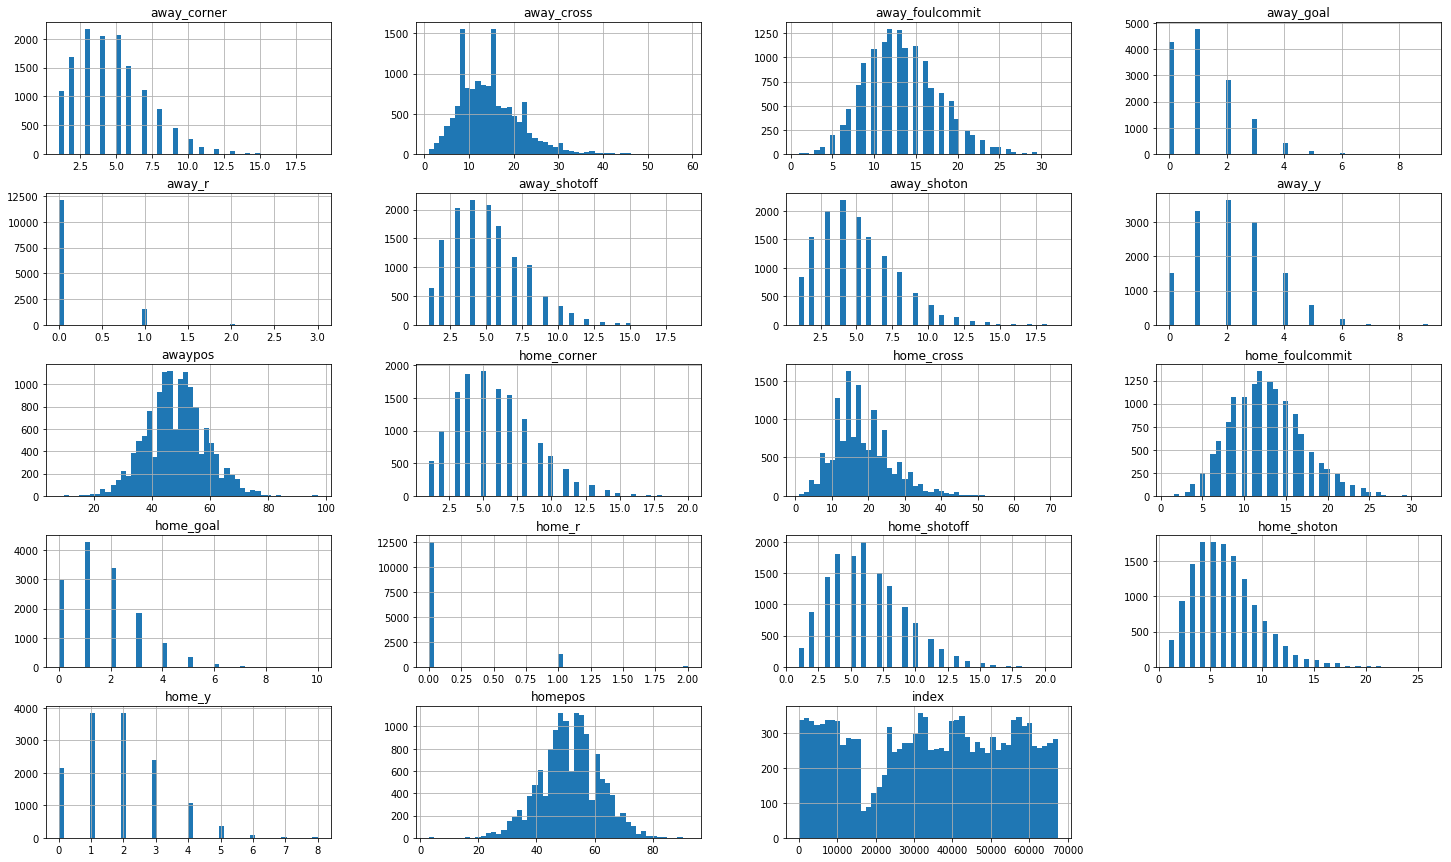

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
matches_features.hist(bins=50, figsize=(25, 15))
plt.show()

Mostly we have smooth, positively-skewed distributions with reasonable values. Home/away_cross and home/awaypos have anomalous-looking peaks, however when we take value_counts they seem to disappear, so this seems to be an issue with pyplot rather than the actual data:

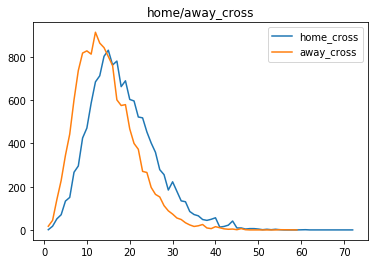

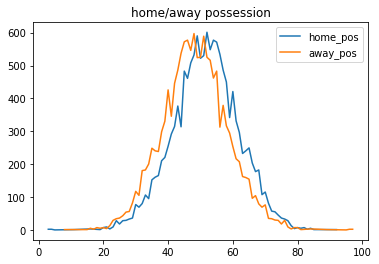

In [207]:
home_cross=pd.DataFrame(matches_features["home_cross"].value_counts()).sort_index()
away_cross=pd.DataFrame(matches_features["away_cross"].value_counts()).sort_index()
plt.plot(home_cross)
plt.plot(away_cross)
plt.title("home/away_cross")
plt.legend(["home_cross", "away_cross"])
plt.show()

home_pos=pd.DataFrame(matches_features["homepos"].value_counts()).sort_index()
away_pos=pd.DataFrame(matches_features["awaypos"].value_counts()).sort_index()
plt.plot(home_pos)
plt.plot(away_pos)
plt.title("home/away possession")
plt.legend(["home_pos", "away_pos"])
plt.show()

Let's try some boxplot. Hopefully, the match results are going to see reasonably distinct patterns:

Text(0.5,0.98,'')

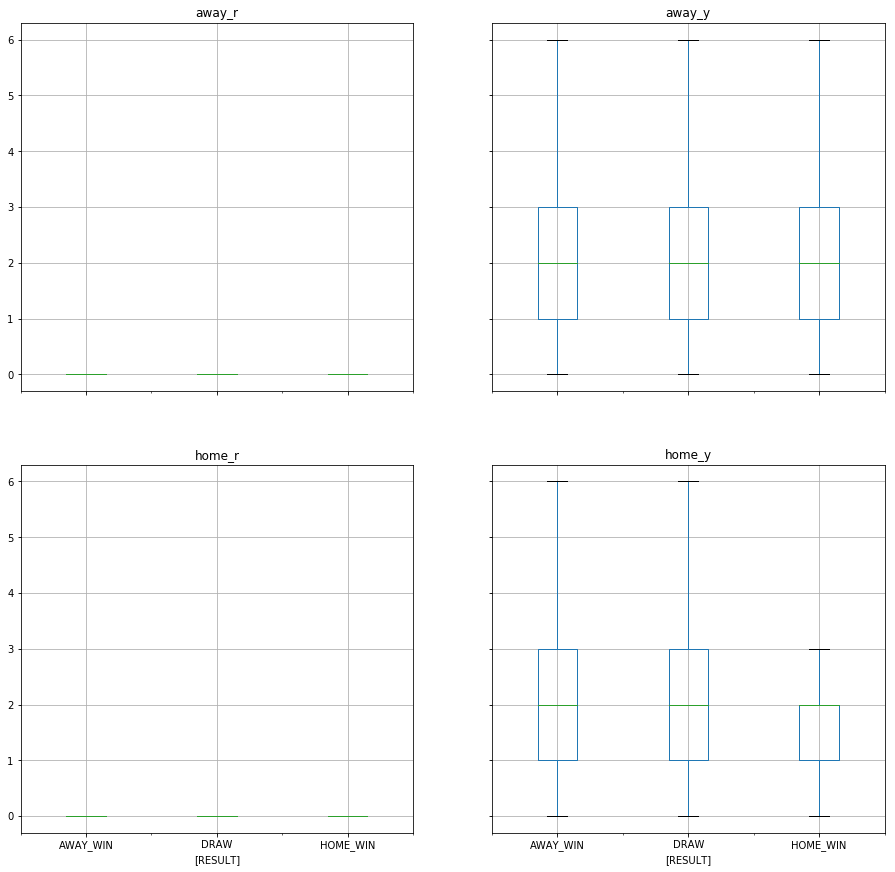

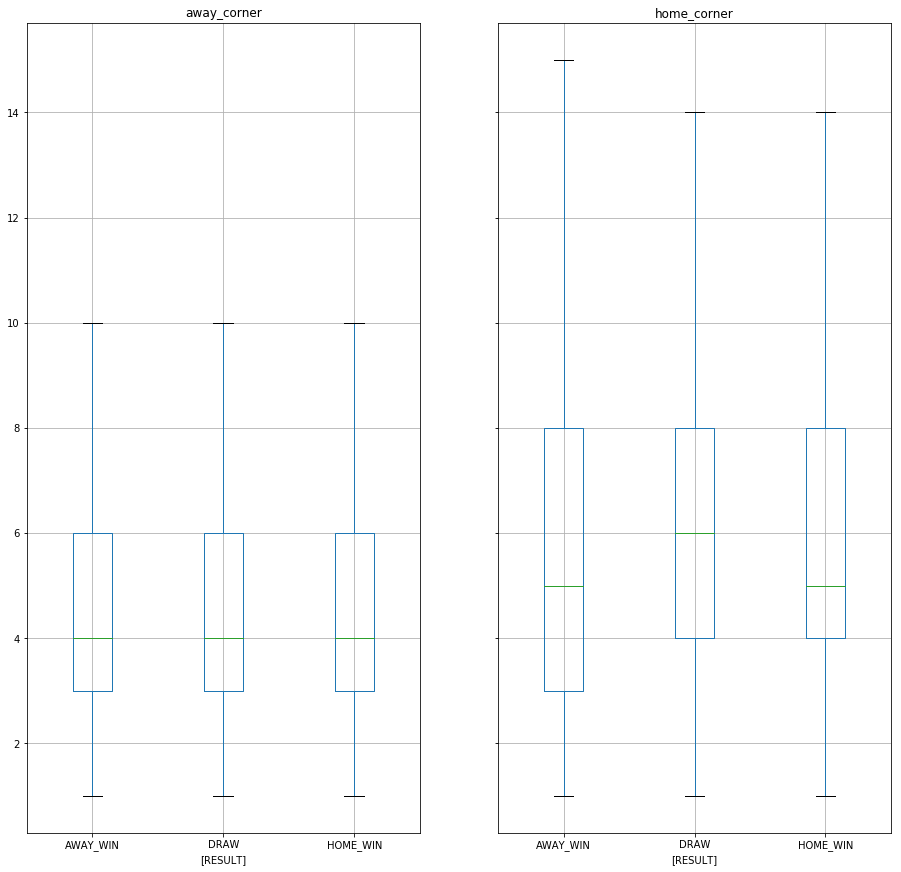

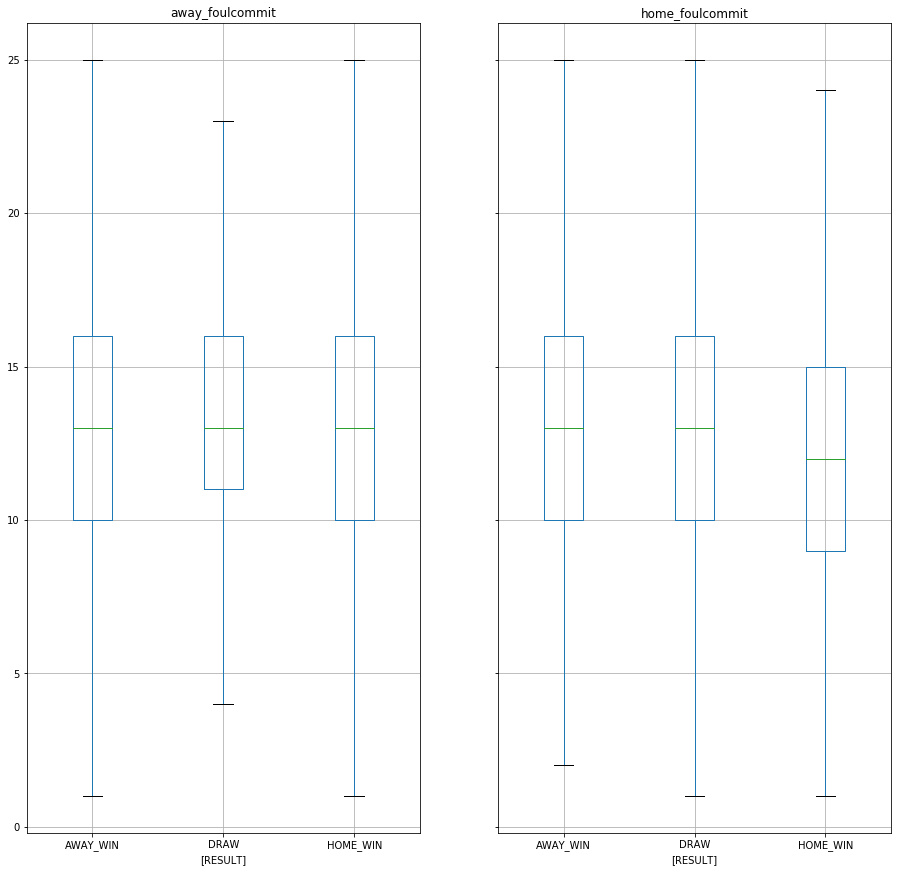

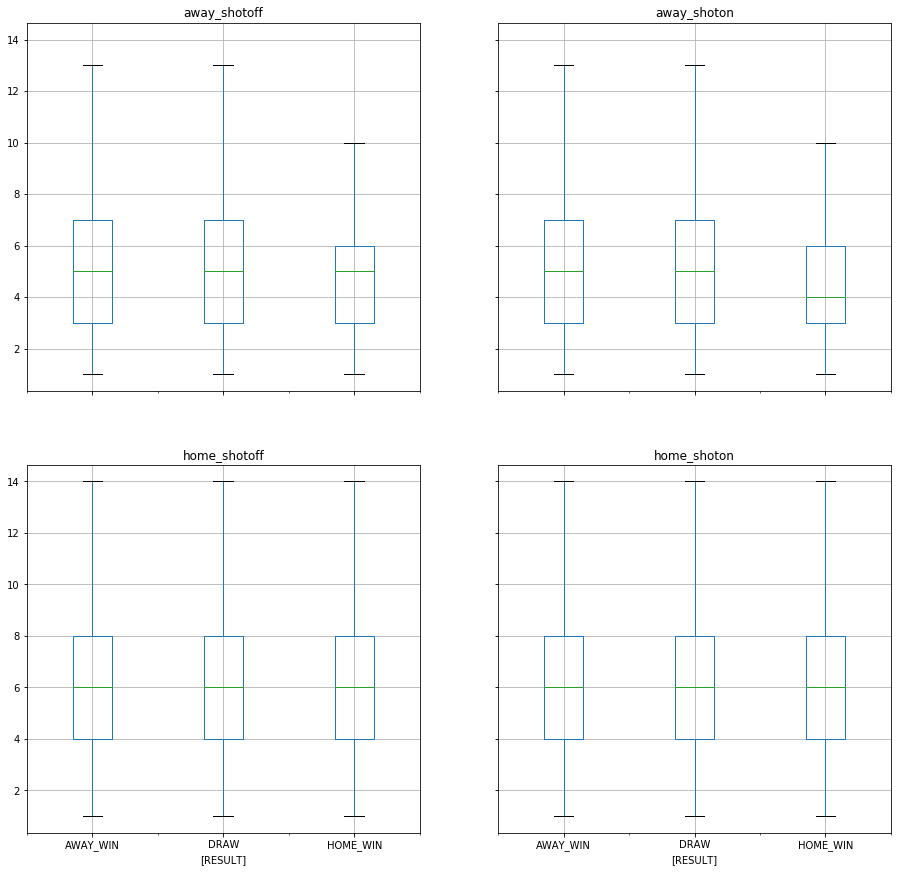

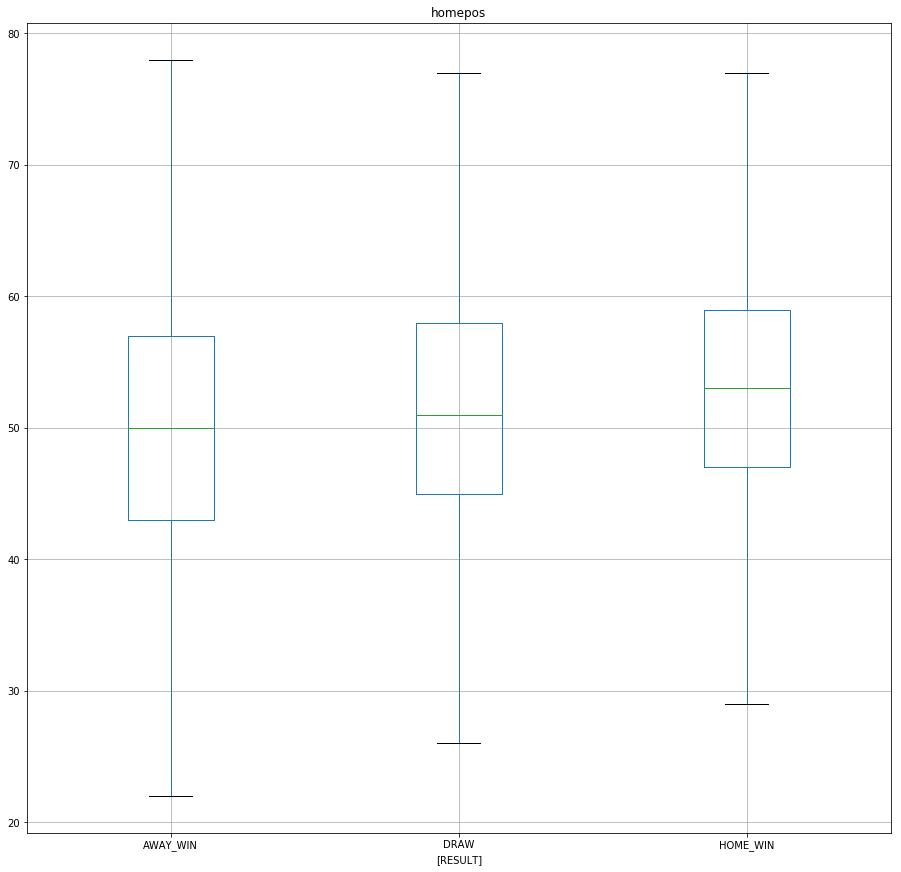

In [153]:
boxplot = matches_features[["RESULT","away_r", "home_r", "away_y", "home_y"]].boxplot(by='RESULT',  showfliers=False, figsize=(15,15))

plt.suptitle("")

boxplot = matches_features[["RESULT", "home_corner", "away_corner"]].boxplot(by='RESULT', showfliers=False, figsize=(15,15))

plt.suptitle("")

boxplot = matches_features[["RESULT", "home_foulcommit", "away_foulcommit"]].boxplot(by='RESULT', showfliers=False, figsize=(15,15))

plt.suptitle("")

boxplot = matches_features[["RESULT", "home_shotoff", "home_shoton", "away_shotoff", "away_shoton"]].boxplot(by='RESULT', showfliers=False, figsize=(15,15))

plt.suptitle("")

boxplot = matches_features[["RESULT", "homepos"]].boxplot(by='RESULT',  showfliers=False, figsize=(15,15))

plt.suptitle("")

This is a bit inauspicious. The spreads for most variables look very similar. Looking at correlations for goals doesn't inspire much hope either:

In [157]:
corr_matrix=matches_features.corr()

print(corr_matrix["home_goal"].sort_values(ascending=False))
print("          ")
print(corr_matrix["away_goal"].sort_values(ascending=False))

home_goal          1.000000
homepos            0.140586
away_r             0.118646
home_shoton        0.063488
index              0.030523
home_corner        0.027254
home_shotoff       0.016367
away_y            -0.006494
away_foulcommit   -0.044591
away_cross        -0.053409
away_corner       -0.059842
home_r            -0.067989
away_shoton       -0.073983
away_goal         -0.076599
away_shotoff      -0.084635
home_cross        -0.093457
home_foulcommit   -0.097878
home_y            -0.119427
awaypos           -0.189791
Name: home_goal, dtype: float64
          
away_goal          1.000000
awaypos            0.159512
home_r             0.128756
home_y             0.099719
away_shoton        0.074792
away_corner        0.034736
away_shotoff       0.024646
home_cross         0.015360
home_foulcommit    0.014539
index              0.010639
home_corner       -0.037999
home_shotoff      -0.038314
away_foulcommit   -0.046805
away_y            -0.049171
home_shoton       -0.056889
away_

One more gambit before we try running some models. Maybe "accuracy" - the ratio of shots on target to total shots - might be somewhat indicative?

In [158]:
matches_features["away_acc"]=matches_features["away_shoton"]/matches_features["away_shots"]
matches_features["home_acc"]=matches_features["home_shoton"]/matches_features["home_shots"]

corr_matrix=matches_features.corr()
corr_matrix["home_goal"].sort_values(ascending=False)


home_goal          1.000000
homepos            0.140586
away_r             0.118646
home_shoton        0.063488
home_acc           0.050293
home_shots         0.050244
index              0.030523
home_corner        0.027254
home_shotoff       0.016367
away_acc          -0.000699
away_y            -0.006494
away_foulcommit   -0.044591
away_cross        -0.053409
away_corner       -0.059842
home_r            -0.067989
away_shoton       -0.073983
away_goal         -0.076599
away_shotoff      -0.084635
home_cross        -0.093457
away_shots        -0.097628
home_foulcommit   -0.097878
home_y            -0.119427
awaypos           -0.189791
Name: home_goal, dtype: float64

Not especially. So far, the book I'm working from hasn't gone into the mechanics of how the classification algorithms used in Chapters 2 and 3 work, but I think it is reasonable to suppose that they are going to have a hard time when there is so little to tell the classifications apart. Never mind, here goes...

# Classification

To get a baseline, we'll start by doing nothing in pre-processing but applying a null-value imputer and label encoder. We'll apply the SGD Classifier and use cross-valuation to see how it's doing:

In [171]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import SGDClassifier


#encoding labels
le = preprocessing.LabelEncoder()
le.fit(matches_features["RESULT"])

y=le.transform(matches_features["RESULT"])
X=matches_features.drop(columns=["home_goal", "away_goal", "RESULT"])

#applying null-value imputer
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0 )),
        
    ])
X_pipe = num_pipeline.fit_transform(X)

#splitting out training data
X_train, X_test, y_train, y_test = train_test_split(X_pipe, y, test_size=0.2, random_state=42)

#applying classifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

#taking cross-valuation scores
cross_vals=cross_val_score(sgd_clf, X_train, y_train, cv=12, scoring="accuracy")
print(cross_vals)
print(np.mean(cross_vals))

[0.45720477 0.24702059 0.45770065 0.45878525 0.2527115  0.29718004
 0.45711183 0.29750271 0.24647123 0.24456522 0.30108696 0.45652174]
0.34782187348610843


Oh dear. Even by my fairly low expectations, that is rather brutal - performing no better than random chance! Can we do any better by applying scaler imputer?

In [172]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0 )),
        ('std_scaler', StandardScaler()),
        
    ])


X_pipe = num_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pipe, y, test_size=0.2, random_state=42)

sgd_clf=SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train)



cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.50519657, 0.52305606, 0.49615559, 0.48620534, 0.51221719])

Better, but still unimpressive. The only other tool I have at my disposal is to try a GridSearchCV. I'm not going to monkey with hyperparameters I don't understand, but let's have a look at a few learning rate values to see if this helps:

In [188]:
from sklearn.model_selection import GridSearchCV

param_grid=  [
    {'alpha': [0.0001, 0.001, 0.01, 0.1]}
]

grid_search=GridSearchCV(sgd_clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_



SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

OK, let's try it out:

In [187]:
sgd_clf=SGDClassifier(random_state=42, alpha=0.01)

sgd_clf.fit(X_train, y_train)

cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.51468595, 0.52893309, 0.50655812, 0.50927182, 0.50723982])

That was underwhelming. 

Let's do a bit of a post-mortum and us a confusion matrix to see where the classification errors were clustered:

[[1102   62 2138]
 [ 542   36 2116]
 [ 485   38 4538]]


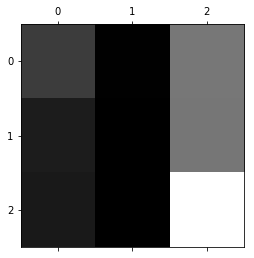

In [197]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train, cv=5)
conf_mx=confusion_matrix(y_train, y_train_pred)


conf_mx=confusion_matrix(y_train, y_train_pred)

print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
#0 = away_win, 1=draw, 2=home_win

So rather interestingly, the classifier is labelling very few matches as draws. A low-resolution explanation for this seems to be that draws just don't have enough discerning features to be clearly identifiable, given the exetent to which the feature variables overlap across classifications. Discounting draws, the algorithm is correctly classifying 67% of the time - still not good, but it does give an indication of how big a problem this is causing. 

I don't think there's much I can do about this now, but it will be interesting to look out for future incidents where feature boundries overlap and a classification that should be sitting between two sets of boundries gets "lost" in this way. 

# Conclusion

This hasn't been a roaring success machine learning-wise, but I've got to utilise a lot of core Python syntax and explored a couple of novel data formats. 

I'm looking forward to future chapters giving a better idea of what is happening mathemetically, which should make it a bit easier to understanding why an algorithm is underperforming. 